In [2]:
!pip install -r requirements.txt --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [215]:
%matplotlib inline
import pymc as pm
import numpy as np
import pandas as pd
from scipy.stats import norm, binom, bernoulli, lognorm
from scipy.special import expit as inv_logit
from scipy.special import logit ,logsumexp, softmax
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import arviz as az
import networkx as nx
import xarray as xr

import collections.abc
collections.Iterable = collections.abc.Iterable
from causalgraphicalmodels import CausalGraphicalModel
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
from matplotlib.patches import FancyArrowPatch

import warnings
warnings.filterwarnings('ignore')


%config InlineBackend.figure_format = 'retina'

plt.style.use(['seaborn-v0_8-darkgrid','seaborn-v0_8-colorblind'])

#### Code 11.1

In [3]:
d = pd.read_csv('data/chimpanzees.csv', sep =';')
d.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


#### Code 11.2

In [4]:
d['treatment'] = d.prosoc_left + 2 * d.condition #we're going to leave out the '1+' to keep it zero-indexed

#### Code 11.3

In [5]:
pd.crosstab([d['treatment'], d['prosoc_left']], d['condition'])

,condition,0,1
treatment,prosoc_left,,
0,0,126,0
1,1,126,0
2,0,0,126
3,1,0,126


#### Code 11.4

In [7]:
with pm.Model() as m11_1:
    a = pm.Normal('a',0,10)
    p = pm.Deterministic('p',pm.math.sigmoid(a))
    pulled_left = pm.Bernoulli('pulled_left',p, observed = d.pulled_left)
    trace_m11_1 = pm.sample(cores =1)

    #Note: These priors are bad on purpose. Its no impossible to get a sampling error here. If so just run it again until
    # the sampling error goes away.


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


#### Code 11.5

In [8]:
with m11_1:
    prior = pm.sample_prior_predictive(1000)


Sampling: [a, pulled_left]


#### Code 11.6

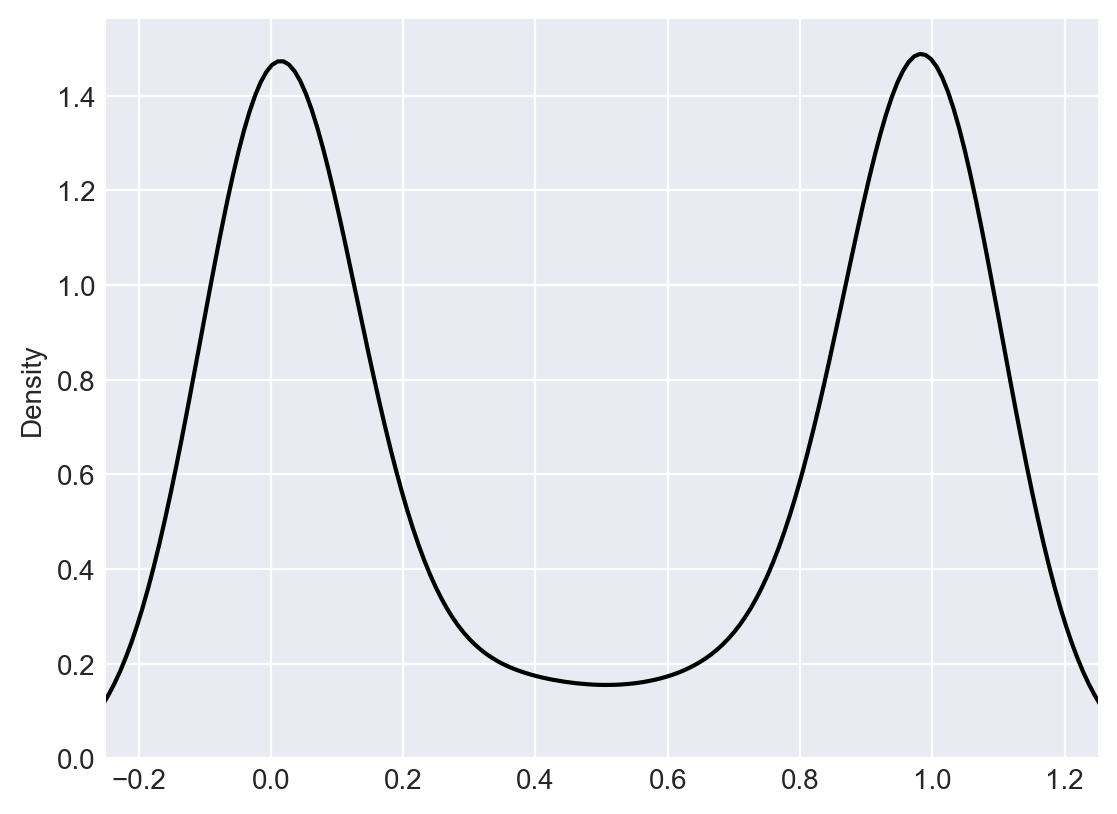

In [9]:
p = inv_logit(prior.prior.a.values.flatten())
sns.kdeplot(p, color = 'black');
plt.xlim(-.250,1.25);

# note sns.kdeplot uses kernel smoothing so it will predict values > 1 and < 0 
# but this is not the case if you inspect the actual values of the data. its a artifact of the graphing mechanism.


#### Code 11.7

In [10]:
with pm.Model() as m11_2:
    b = pm.Normal('b',0,10, shape = len(d.treatment.unique()))
    a = pm.Normal('a', 0, 1.5)
    p = pm.Deterministic('p', pm.math.sigmoid(a + b[d.treatment]))
    pulled_left = pm.Binomial('pulled_left', n = 1, p = p, observed = d.pulled_left)
    trace_m11_2 = pm.sample(cores = 1)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [11]:

with m11_2:
    prior = pm.sample_prior_predictive(1000).prior.to_dataframe().reset_index()


Sampling: [a, b, pulled_left]


#### Code 11.7

In [12]:
with m11_2:
    prior = pm.sample_prior_predictive(1000).prior.to_dataframe().reset_index()


Sampling: [a, b, pulled_left]


#### Code 11.8

#### Code 11.9

In [13]:
with pm.Model() as m11_3:
    b = pm.Normal('b',0,.5, shape = len(d.treatment.unique()))
    a = pm.Normal('a',0,1.5)
    p = pm.Deterministic('p', pm.math.sigmoid(a + b[d.treatment]))
    pulled_left = pm.Binomial('pulled_left', n = 1, p = p, observed = d.pulled_left)
    trace_m11_3 = pm.sample(cores = 1, progressbar = False, kwargs = {'return_inferencedata': True})
    prior_m11_3 = pm.sample_prior_predictive(1000).prior.to_dataframe().reset_index() 

p = [inv_logit(prior_m11_3.a[prior_m11_3.b_dim_0 == i].values + 
                      prior_m11_3.b[prior_m11_3.b_dim_0 == i].values)
            for i in range(d.treatment.nunique())]
abs(p[0] - p[1]).mean()

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [a, b, pulled_left]


0.09391333601313685

#### Code 11.10

In [14]:
dat_list = pd.DataFrame(
    {'pulled_left': d.pulled_left,
    'actor': d.actor - 1, # must be zero-indexed
    'treatment': d.treatment}
)


#### Code 11.11

In [15]:
with pm.Model() as m11_4:
    a = pm.Normal('a', 0, 1.5, shape = len(dat_list.actor.unique()))
    b = pm.Normal('b', 0, .5, shape = (len(dat_list.treatment.unique())))
    p = pm.Deterministic('p', pm.math.sigmoid(a[dat_list.actor] + b[dat_list.treatment]))
    pulled_left = pm.Binomial('pulled_left', n = 1, p = p, observed = dat_list.pulled_left)
    trace_m11_4 = pm.sample(cores = 1, progressbar = False, idata_kwargs = {'log_likelihood': True})

pm.summary(trace_m11_4, var_names = ['a','b'])

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.452,0.337,-1.081,0.179,0.011,0.008,898.0,1418.0,1.00
a[1],3.880,0.776,2.487,5.302,0.017,0.012,2027.0,1521.0,1.00
a[2],-0.749,0.334,-1.342,-0.089,0.011,0.008,878.0,1345.0,1.01
a[3],-0.757,0.336,-1.371,-0.167,0.011,0.008,1003.0,1415.0,1.00
a[4],-0.455,0.323,-1.091,0.107,0.011,0.008,914.0,1159.0,1.00
a[5],0.468,0.326,-0.179,1.024,0.011,0.008,861.0,1251.0,1.01
a[6],1.946,0.419,1.214,2.776,0.012,0.008,1243.0,1309.0,1.00
b[0],-0.033,0.287,-0.554,0.505,0.010,0.007,765.0,1299.0,1.01
b[1],0.487,0.286,-0.095,0.971,0.010,0.007,861.0,1380.0,1.00
b[2],-0.372,0.282,-0.897,0.155,0.010,0.007,815.0,1245.0,1.01


#### Code 11.12

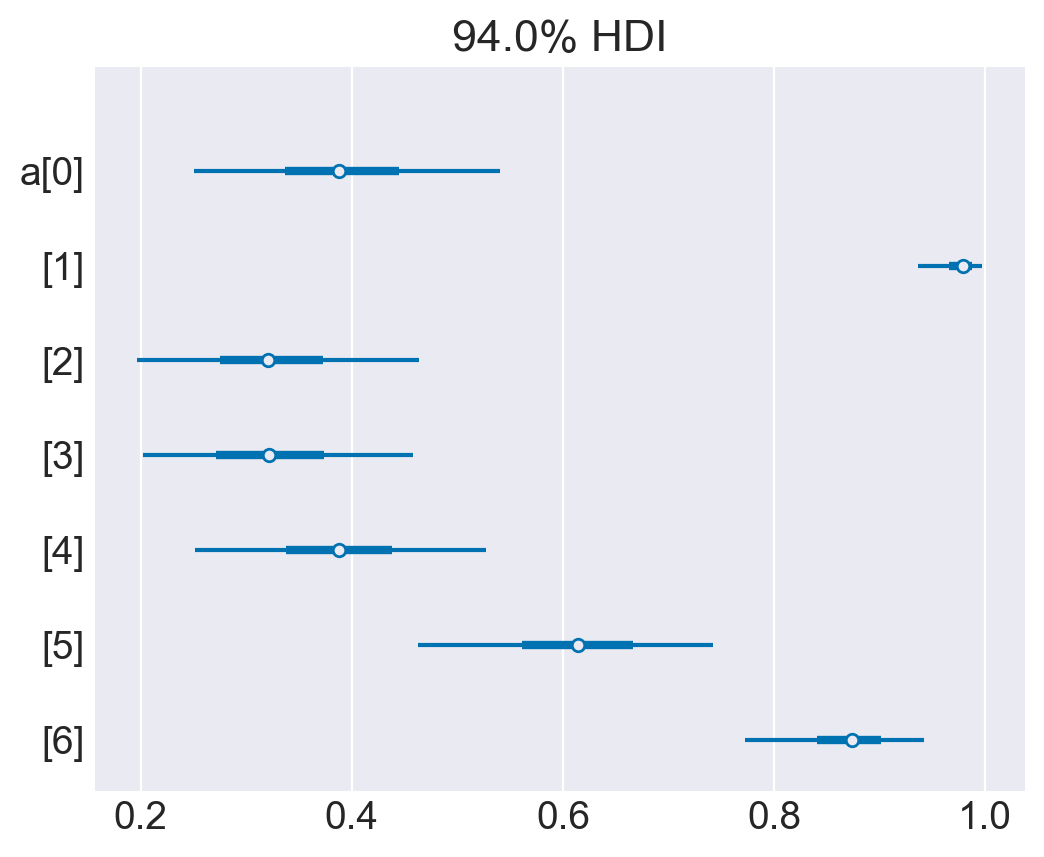

In [16]:
post = trace_m11_4.posterior
post['a'] = inv_logit(trace_m11_4.posterior['a'])

az.plot_forest(post, var_names=['a'], combined=True);


### Code 11.13

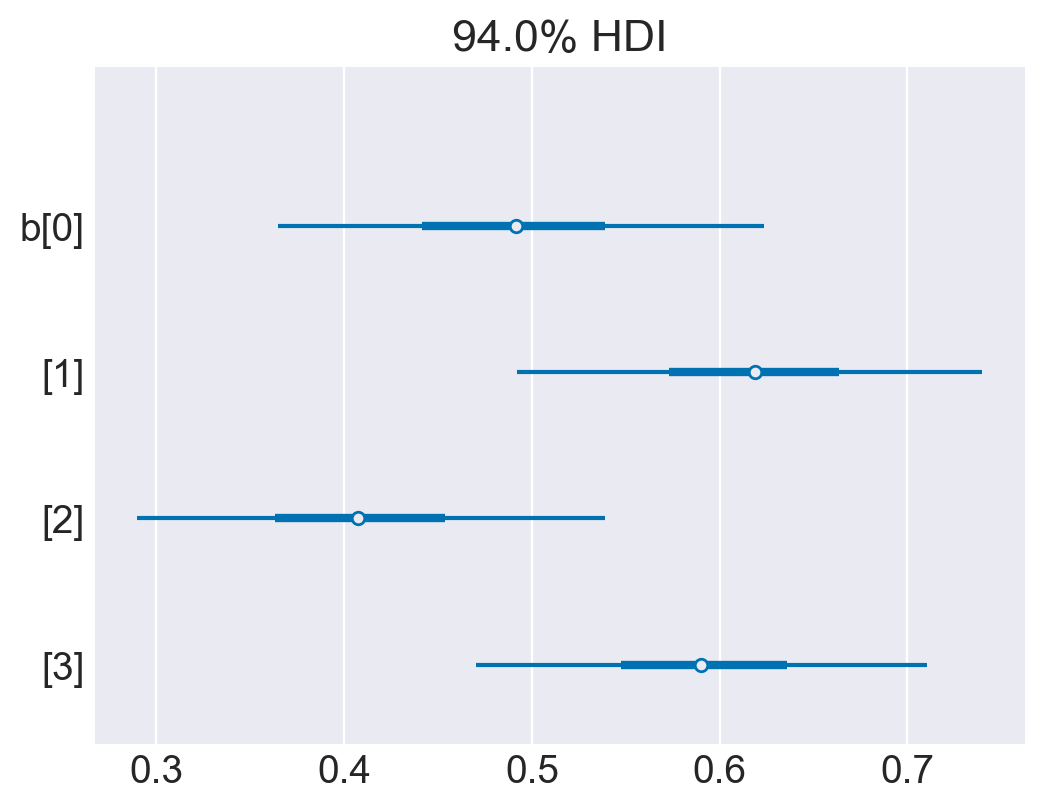

In [17]:
post = trace_m11_4.posterior
post['b'] = inv_logit(trace_m11_4.posterior['b'])

az.plot_forest(post, var_names=['b'], combined=True);

#in order to change the y axis labels we'll need to feed coords into the model at the beginning


#### Code 11.14

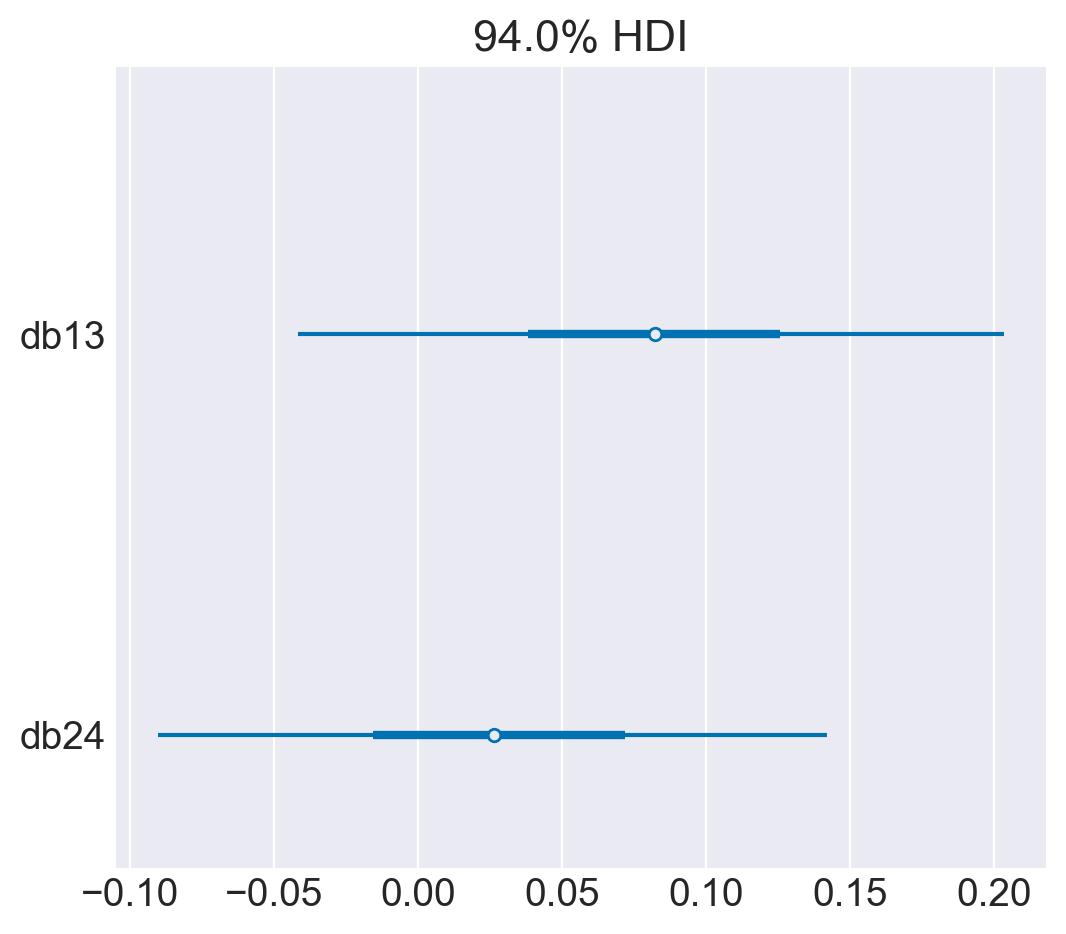

In [18]:
post['db13'] = trace_m11_4.posterior['b'].sel(b_dim_0 = 0)- trace_m11_4.posterior['b'].sel(b_dim_0 = 2)
post['db24'] = trace_m11_4.posterior['b'].sel(b_dim_0 = 1) - trace_m11_4.posterior['b'].sel(b_dim_0 = 3)


az.plot_forest(post, var_names=['db13','db24'], combined=True);

#### Code 11.15



#### Code 11.15

In [19]:
pl = d.groupby(['actor', 'treatment'])['pulled_left'].mean()
pl[1,:]


treatment
0    0.333333
1    0.500000
2    0.277778
3    0.555556
Name: pulled_left, dtype: float64

#### Code 11.16

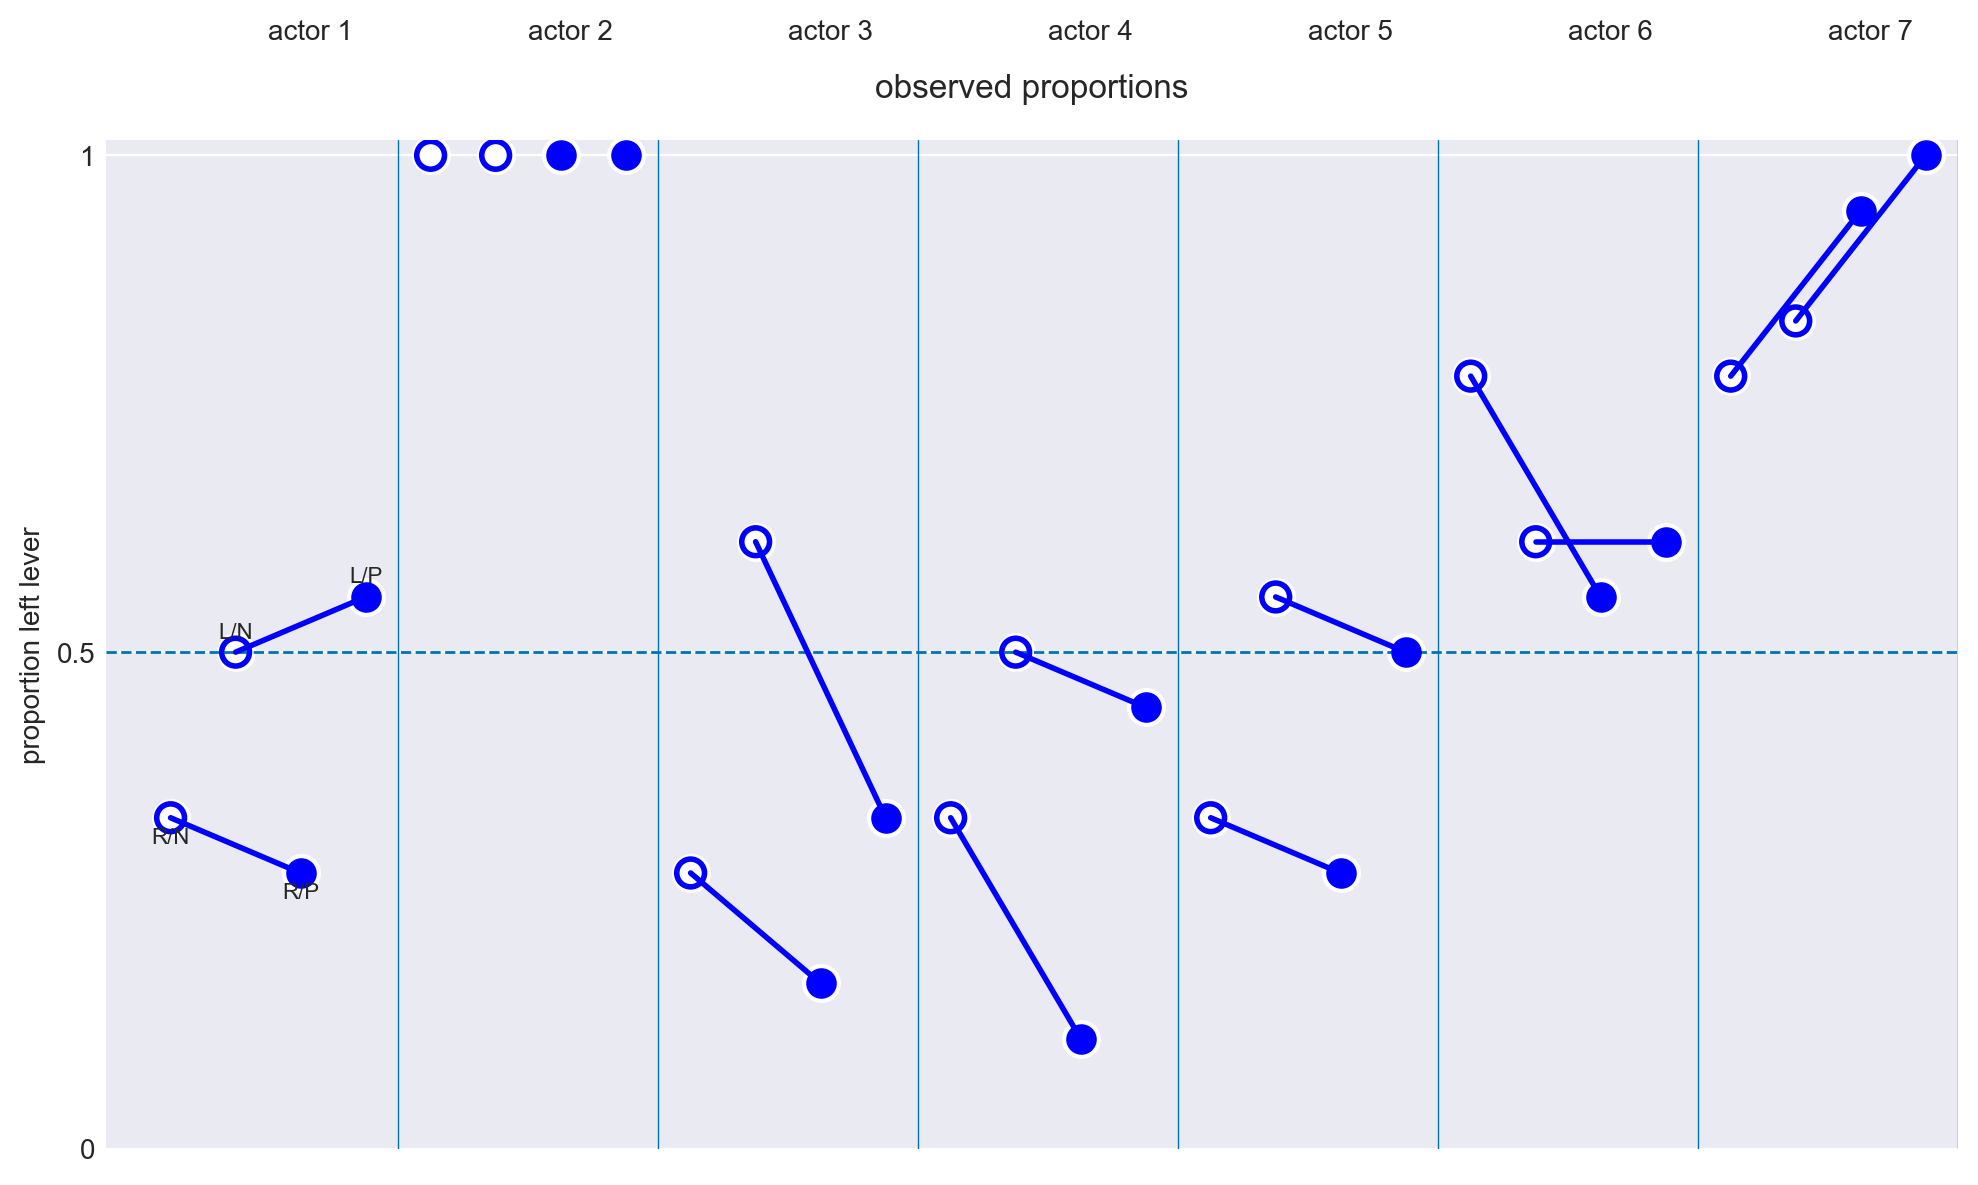

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 28.5)
ax.set_ylim(0, 1.015)
ax.set_xlabel("")
ax.set_ylabel("proportion left lever")
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0, 0.5, 1])
ax.set_title("observed proportions\n", ha='center', va='center', fontsize=12)


ax.axhline(y=0.5, linestyle='--', linewidth=1)

for j in range(7):
    ax.axvline(x=(j)*4+4.5, linewidth=0.5)

for j in range(7):
    ax.text((j)*4+2.5, 1.1, f"actor {j+1}", transform=ax.get_xaxis_transform())

pl = d.groupby(['actor', 'treatment'])['pulled_left'].mean()
pl_array = pl.unstack().values  
for j in [1, 3, 4, 5, 6, 7]:
    ax.plot([(j-1)*4+1, (j-1)*4+3], [pl_array[j-1, 0], pl_array[j-1, 2]], 
            linewidth=2, color='blue')
    ax.plot([(j-1)*4+2, (j-1)*4+4], [pl_array[j-1, 1], pl_array[j-1, 3]], 
            linewidth=2, color='blue')

y_vals = pl_array.flatten()
ax.scatter(range(1, 29), y_vals, marker='o', color='white', s=170, zorder=1)

x_vals = np.arange(1, 29)
for i, (x, y) in enumerate(zip(x_vals, y_vals)):
    if i % 4 in [0, 1]:
        ax.scatter(x, y, marker='o', color='blue', s=100, 
                  facecolors='none', edgecolors='blue', linewidths=2, zorder=2)
    else:
        ax.scatter(x, y, marker='o', color='blue', s=100, zorder=2)

yoff = 0.01
ax.text(1, pl_array[0, 0]-yoff, "R/N", ha='center', va='top', fontsize=8)
ax.text(2, pl_array[0, 1]+yoff, "L/N", ha='center', va='bottom', fontsize=8)
ax.text(3, pl_array[0, 2]-yoff, "R/P", ha='center', va='top', fontsize=8)
ax.text(4, pl_array[0, 3]+yoff, "L/P", ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

#### Code 11.17

In [21]:
actor_idx = np.repeat(np.arange(7), 4)
treatment_idx = np.tile(np.arange(4), 7)

post = trace_m11_4.posterior

a_samples = post['a'].values  
b_samples = post['b'].values  

a_flat = a_samples.reshape(-1, 7)  
b_flat = b_samples.reshape(-1, 4)  

mu = inv_logit(a_flat[:, actor_idx] + b_flat[:, treatment_idx])

p_mu = mu.mean(1)
p_ci = az.hdi(mu, hdi_prob=0.89)


#### Code 11.18

In [22]:
d['side'] = d.prosoc_left + 1 
d['cond'] = d.condition + 1 

d.sample(10)

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment,side,cond
251,4,NaN,0,6,71,1,1,1,1,2,1
300,5,NaN,0,3,26,1,0,0,1,2,1
14,1,NaN,0,3,30,0,1,0,0,1,1
116,2,5.0,1,2,16,1,1,1,3,2,2
456,7,NaN,0,5,49,1,1,1,1,2,1
66,1,3.0,1,6,61,1,1,1,3,2,2
457,7,NaN,0,5,51,0,0,1,0,1,1
76,2,NaN,0,1,9,1,1,1,1,2,1
482,7,6.0,1,3,30,1,1,1,3,2,2
184,3,8.0,1,1,10,1,0,0,3,2,2


#### Code 11.19

In [ ]:
dat_list2 = pd.DataFrame(
    {'pulled_left': d.pulled_left,
    'actor': d.actor - 1, 
    'treatment': d.treatment,
    'side': d.side,
    'cond': d.cond}
)

with pm.Model() as m11_5:
    a = pm.Normal('a', 0, 1.5, shape = len(dat_list2.actor.unique()))
    bs = pm.Normal('b', 0, .5, shape = (len(dat_list2.treatment.unique())))
    bc = pm.Normal('bc', 0, .5, shape = (len(dat_list2.cond.unique())))
    p = pm.Deterministic('p', pm.math.sigmoid(a[dat_list2.actor] + bs[dat_list2.treatment] + bc[dat_list2.cond]))
    pulled_left = pm.Binomial('pulled_left', n = 1, p = p, observed = dat_list2.pulled_left)
    trace_m11_5 = pm.sample(cores = 1, chains = 4, progressbar = True, idata_kwargs = {'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...


#### Code 11.20

In [ ]:
az.compare({'m11_4': trace_m11_4, 'm11_5': trace_m11_5})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m11_4,0,-266.041631,8.421822,0.000000,0.935685,9.463768,0.000000,False,log
m11_5,1,-266.071524,8.522067,0.029893,0.064315,9.574197,0.261946,False,log


#### Code 11.21 - 11.22

_This is largely just code for getting stan to work in R.  We already have pymc._

#### Code 11.23

In [ ]:
post = trace_m11_4.posterior.to_dataframe().reset_index() 
post_a = post.a.loc[post['b_dim_0'] == 3]
post_b = post.b.loc[post['b_dim_0'] == 1]

np.exp(np.mean(post_a.values - post_b.values))




0.9431500070057646

#### Code 12.24

In [ ]:
d = pd.read_csv('data/chimpanzees.csv', sep =';')
d['treatment'] = d.prosoc_left + 2 * d.condition #we're going to leave out the '1+' to keep it zero-indexed
d['side'] = d.prosoc_left 
d['actor'] = d.actor - 1
d['cond'] = d.condition 
d_aggregated = d.groupby(['treatment', 'actor', 'side', 'cond'])['pulled_left'].sum().reset_index()
d_aggregated.rename(columns = {'pulled_left': 'left_pulls'}, inplace = True)

#### Code 11.25

In [ ]:
dat = d_aggregated.copy() 

with pm.Model() as m11_6: 
    a = pm.Normal('a', 0, 1.5, shape = len(dat.actor.unique()))
    b = pm.Normal('b', 0, .5,  shape = len(dat.treatment.unique()))
    p = pm.Deterministic('p', pm.math.sigmoid(a[dat.actor] + b[dat.treatment])) 
    left_pulls = pm.Binomial('left_pulls', n = 18, p = p, observed = dat.left_pulls)
    trace_m11_6 = pm.sample(cores = 1, chains = 4, progressbar = True, idata_kwargs = {'log_likelihood': True})



Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


#### Code 11.26

In [ ]:
az.compare({'m11_4': trace_m11_4, 'm11_6': trace_m11_6})

ValueError: The number of observations should be the same across all models

#### Code 11.27

In [ ]:
print(-2 * binom.logpmf(6,9,.2))
print(-2 * np.sum(bernoulli.logpmf([1,1,1,1,1,1,0,0,0], .2)))

11.790482659407834
20.652116257094463


#### Code 11.28

In [ ]:
d = pd.read_csv('data/UCBadmit.csv', sep = ';')
d.columns

Index(['dept', 'applicant.gender', 'admit', 'reject', 'applications'], dtype='object')

#### Code 11.29

In [ ]:
dat_list = pd.DataFrame(
    {'admit': d.admit,
    'applications': d.applications,
    'gid': np.where(d['applicant.gender'] == 'male', 0, 1)}
)

with pm.Model() as m11_7: 
    a = pm.Normal('a', 0, 1.5, shape = len(dat_list.gid.unique()))
    p = pm.Deterministic('p', pm.math.sigmoid(a[dat_list.gid]))
    admit  = pm.Binomial('admit', n = dat_list.applications, p = p, observed = dat_list.admit)
    trace_m11_7 = pm.sample(cores = 1, chains = 4, progressbar = True, idata_kwargs = {'log_likelihood': True})

pm.summary(trace_m11_7, var_names = ['a'])




Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [a]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.22,0.038,-0.287,-0.148,0.001,0.000,3666.0,2835.0,1.0
a[1],-0.83,0.050,-0.925,-0.736,0.001,0.001,3925.0,2544.0,1.0


#### Code 11.30

In [194]:
trace_m11_12

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
post_m = trace_m11_7.posterior.a.sel(a_dim_0 = 0)
post_f = trace_m11_7.posterior.a.sel(a_dim_0 = 1)

diff_a = post_m - post_f
diff_p = inv_logit(post_m) - inv_logit(post_f)

diff_combined = xr.Dataset({'diff_a': diff_a, 'diff_p': diff_p})

pm.summary(diff_combined, hdi_prob = 0.89)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
diff_a,0.610,0.063,0.503,0.705,0.001,0.001,3788.0,2815.0,1.0
diff_p,0.142,0.014,0.120,0.165,0.000,0.000,3770.0,3139.0,1.0


#### Code 11.31

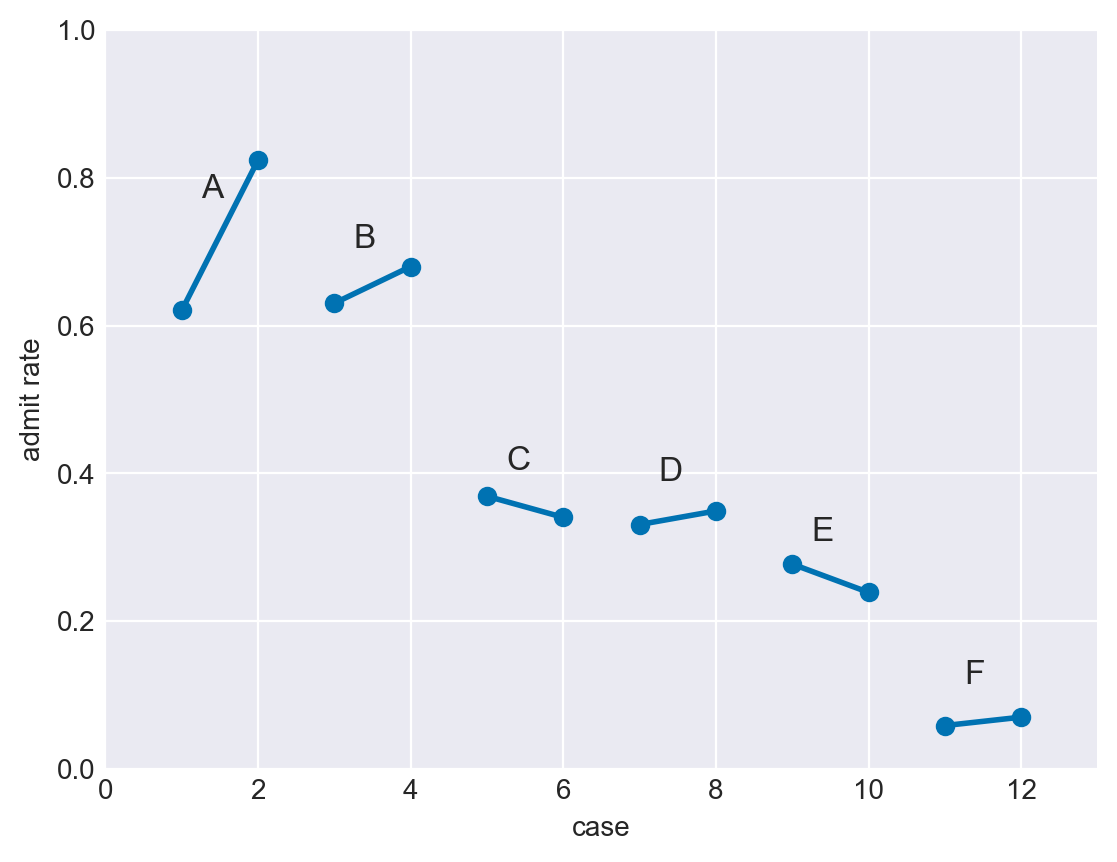

In [ ]:
for i in range(6):
    x = 1 + 2 * i
    y1 = d.admit[x] / d.applications[x]
    y2 = d.admit[x+1] / d.applications[x+1]
    plt.plot([x,x+1], [y1,y2], '-C0o', lw = 2)
    plt.text(x + .25, (y1+y2)/2 + .05, d.dept[x], fontsize = 12)

plt.xlabel('case')
plt.ylabel('admit')
plt.xlim(0,13)
plt.ylim(0,1)
plt.show()


#### Code 11.32

In [ ]:
labels, uniques = pd.factorize(d.dept)
dat_list['dept_id'] = labels

with pm.Model() as m11_8:
    delta = pm.Normal('delta', 0, 1.5, shape = len(dat_list.dept_id.unique()))
    a = pm.Normal('a', 0, 1.5, shape = len(dat_list.gid.unique()))
    p = pm.Deterministic('p', pm.math.sigmoid(a[dat_list.gid] + delta[dat_list.dept_id]))
    admit = pm.Binomial('admit', n = dat_list.applications, p = p, observed = dat_list.admit)
    trace_m11_8 = pm.sample(cores = 1, chains = 4, progressbar = True, idata_kwargs = {'log_likelihood': True})

pm.summary(trace_m11_8, var_names = ['a','delta'])

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [delta, a]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.548,0.507,-1.460,0.408,0.027,0.019,357.0,509.0,1.0
a[1],-0.452,0.510,-1.442,0.449,0.027,0.019,365.0,508.0,1.0
delta[0],1.129,0.510,0.201,2.091,0.027,0.019,363.0,564.0,1.0
delta[1],1.084,0.513,0.118,2.014,0.027,0.019,371.0,551.0,1.0
delta[2],-0.131,0.511,-1.062,0.834,0.027,0.019,362.0,523.0,1.0
delta[3],-0.166,0.511,-1.142,0.738,0.027,0.019,361.0,534.0,1.0
delta[4],-0.606,0.513,-1.576,0.316,0.027,0.019,368.0,579.0,1.0
delta[5],-2.163,0.518,-3.107,-1.189,0.027,0.019,379.0,569.0,1.0


#### Code 11.33

In [ ]:
post_m = trace_m11_8.posterior.a.sel(a_dim_0 = 0)
post_f = trace_m11_8.posterior.a.sel(a_dim_0 = 1)

diff_a = post_m - post_f
diff_p = inv_logit(post_m) - inv_logit(post_f)

diff_combined = xr.Dataset({'diff_a': diff_a, 'diff_p': diff_p})

pm.summary(diff_combined, hdi_prob = 0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
diff_a,-0.096,0.081,-0.228,0.028,0.001,0.001,4673.0,3598.0,1.0
diff_p,-0.022,0.019,-0.049,0.009,0.000,0.000,4145.0,3449.0,1.0


In [ ]:
dat_list
pg = dat_list.groupby(['dept_id', 'gid']).applications.sum() / dat_list.groupby(['dept_id']).applications.sum()
pg = round(pg.unstack(), 2)
pg.columns = ['female', 'male']
pg.index = ['A', 'B', 'C', 'D', 'E', 'F']
pg.T




,A,B,C,D,E,F
female,0.88,0.96,0.35,0.53,0.33,0.52
male,0.12,0.04,0.65,0.47,0.67,0.48


#### Code 11.35

In [ ]:
y = np.random.binomial(n = 1000, p = 1/1000, size = 10000)
[np.mean(y), np.var(y)]

[0.9994, 1.00179964]

#### Code 11.36

In [7]:
d = pd.read_csv('data/Kline.csv', sep = ';')
d

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


#### Code 11.37

In [59]:
d['P'] = scaler.fit_transform(np.log(d[['population']]))
d['contact_id'] = np.where(d.contact == 'high', 1, 0)
d

,culture,population,contact,total_tools,mean_TU,P,contact_id
0,Malekula,1100,low,13,3.2,-1.361332,0
1,Tikopia,1500,low,22,4.7,-1.147433,0
2,Santa Cruz,3600,low,24,4.0,-0.543664,0
3,Yap,4791,high,43,5.0,-0.346558,1
4,Lau Fiji,7400,high,33,5.0,-0.046737,1
5,Trobriand,8000,high,19,4.0,0.007029,1
6,Chuuk,9200,high,40,3.8,0.103416,1
7,Manus,13000,low,28,6.6,0.341861,0
8,Tonga,17500,high,55,5.4,0.546861,1
9,Hawaii,275000,low,71,6.6,2.446558,0


#### Code 11.38

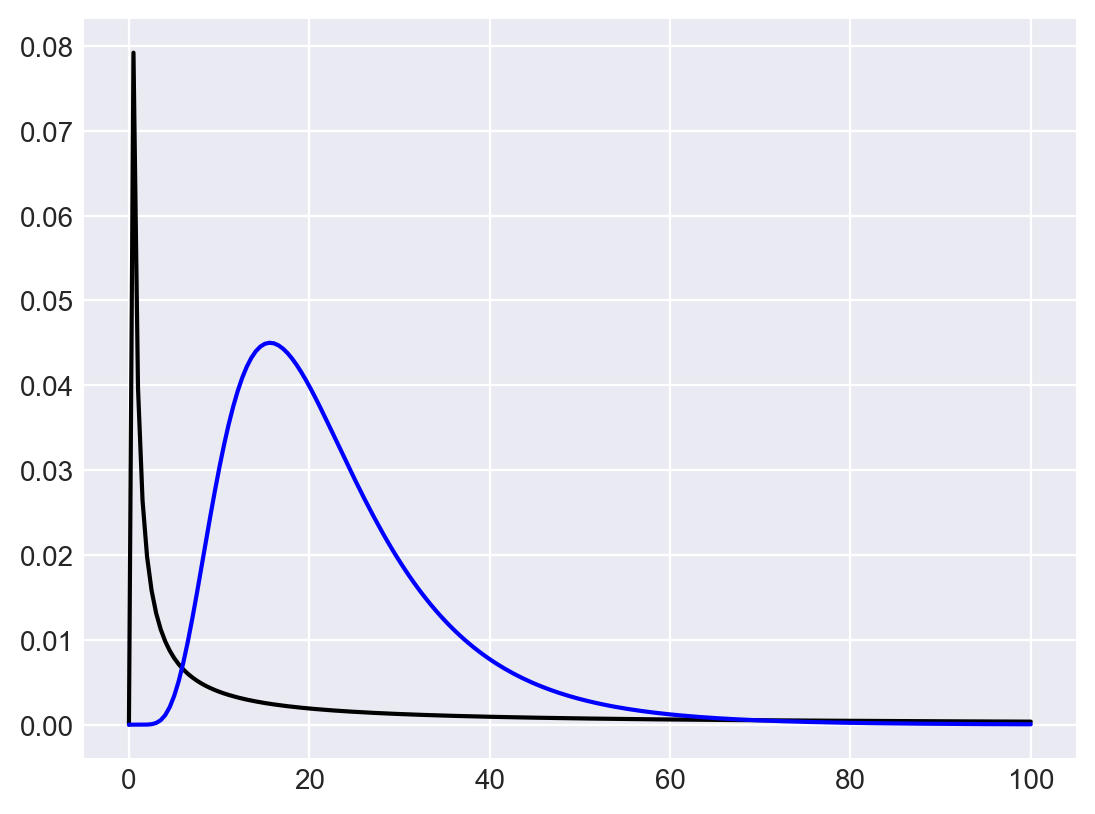

In [60]:
x = np.linspace(0, 100, 200)
plt.plot(x, lognorm.pdf(x, 10, scale=1), color = 'black')
plt.plot(x, lognorm.pdf(x, scale= np.exp(3), s=.5), color = 'blue')

#### Code 11.41

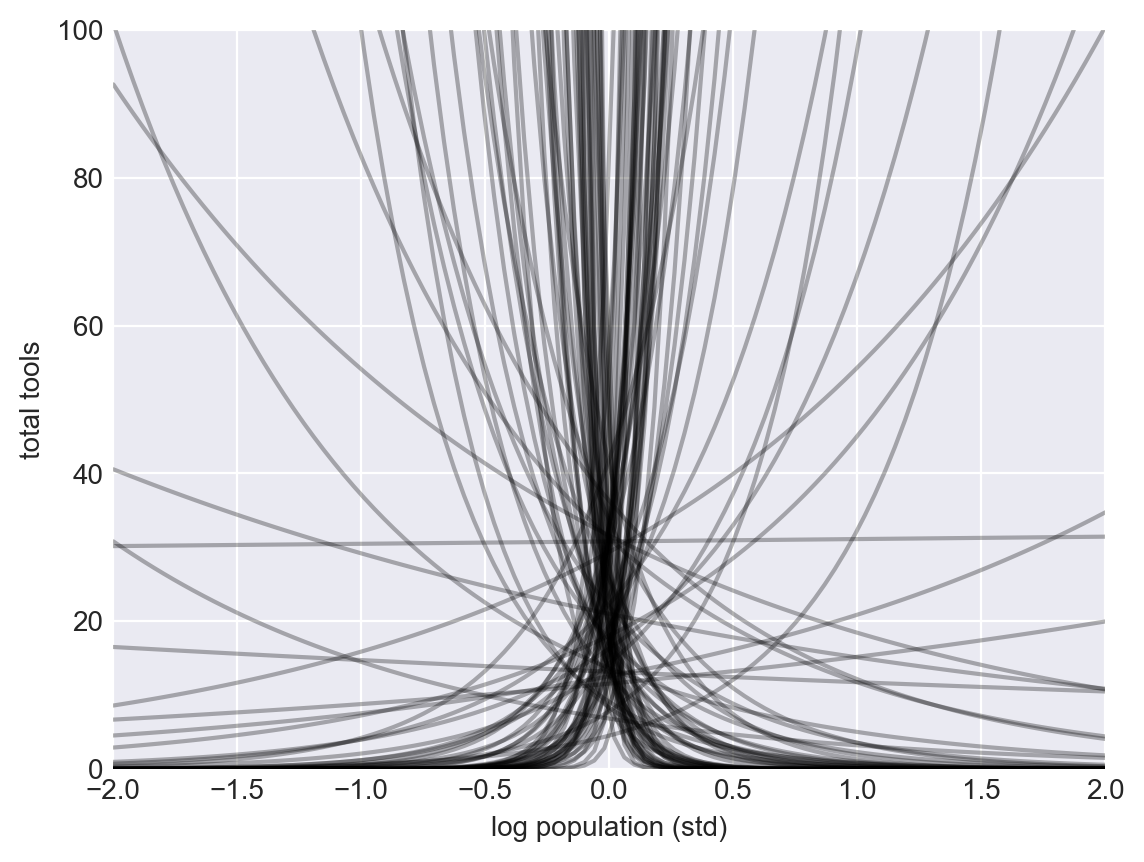

In [61]:
N = 100
x = np.linspace(-2, 2, N)

a = np.random.normal(3, .5, N)
b = np.random.normal(0, 10, N)
for i in range(N):
    plt.plot(x,np.exp(a[i] + b[i] * x), color = 'black', alpha = .3)
plt.xlim(-2,2)
plt.ylim(0,100)
plt.xlabel('log population (std)')
plt.ylabel('total tools');


#### Code 11.42

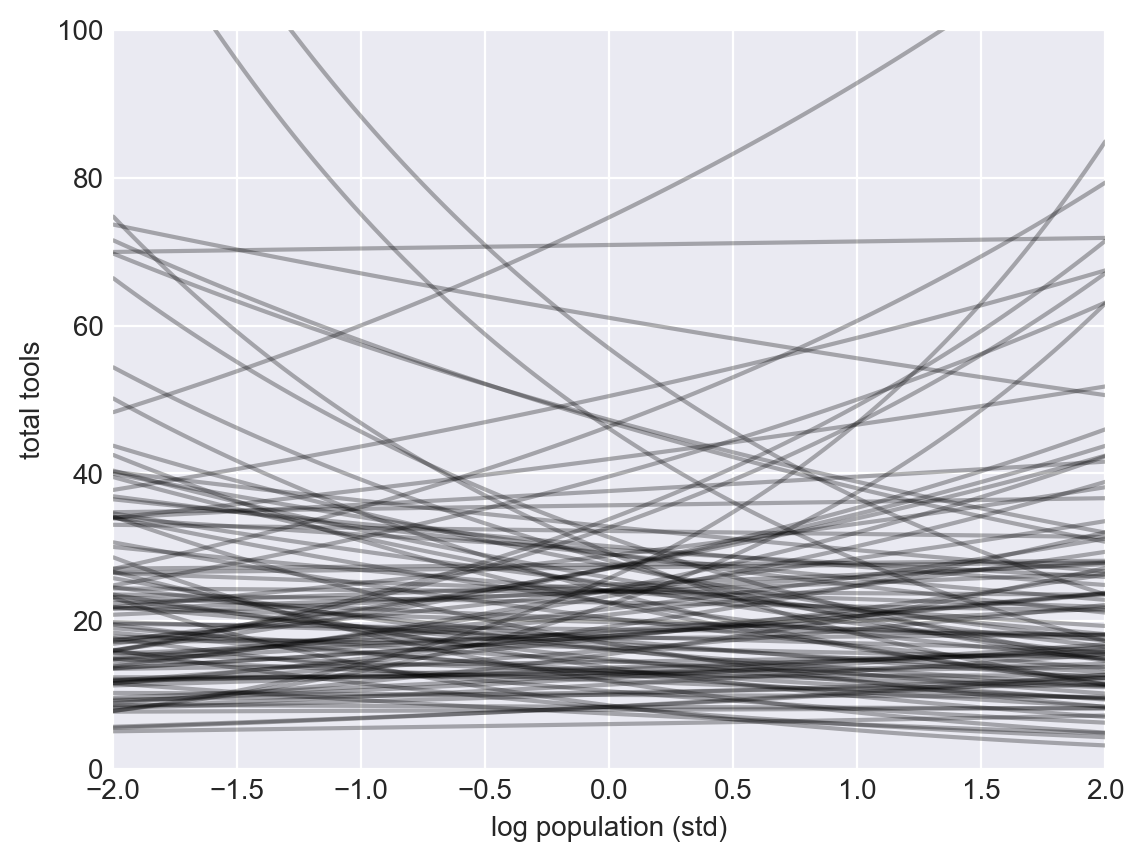

In [62]:
N = 100
x = np.linspace(-2, 2, N)

a = np.random.normal(3, .5, N)
b = np.random.normal(0, .2, N)
for i in range(N):
    plt.plot(x,np.exp(a[i] + b[i] * x), color = 'black', alpha = .3)
plt.xlim(-2,2)
plt.ylim(0,100)
plt.xlabel('log population (std)')
plt.ylabel('total tools');


#### Code 11.43

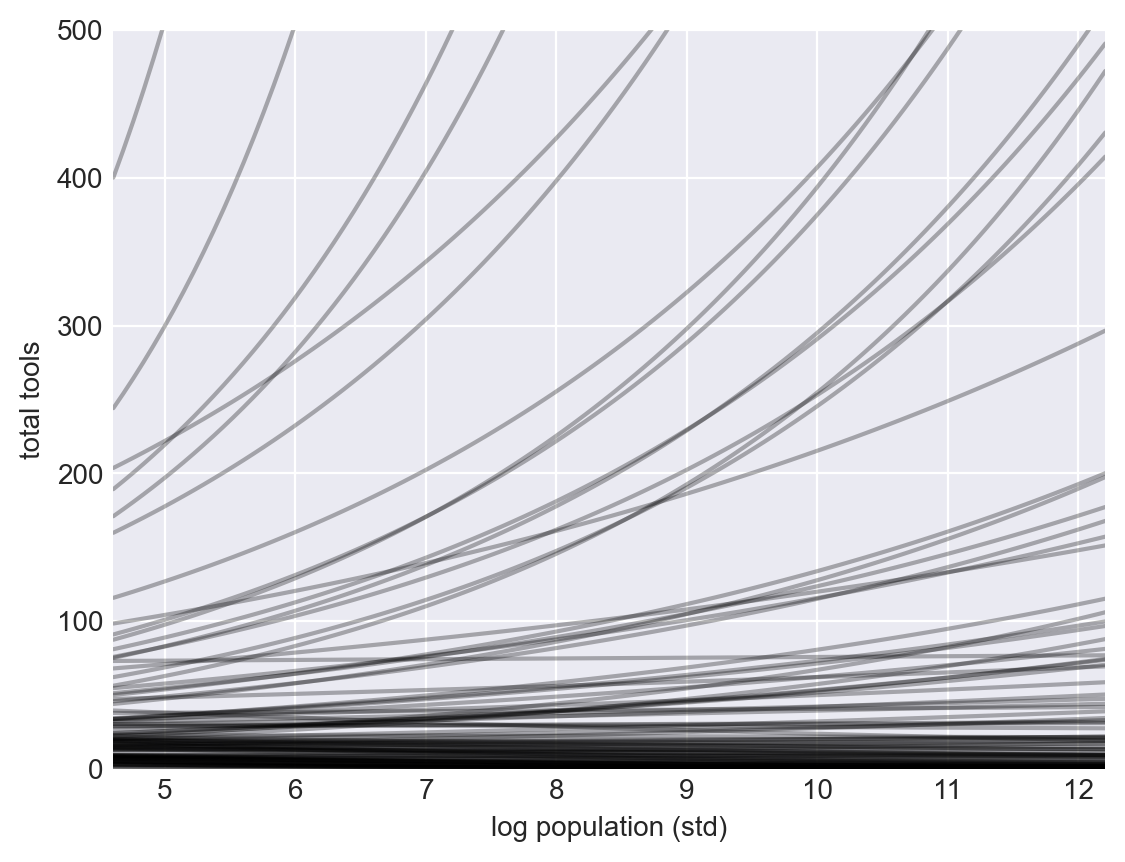

In [63]:
x_seq = np.linspace(np.log(100), np.log(200000), 100)
lambda_vals = np.exp(a[:, None] + b[:, None] * x_seq[None, :])
for i in range(N):
    plt.plot(x_seq, lambda_vals[i, :], color = 'black', alpha = .3)
plt.xlim(x_seq[0], x_seq[-1])
plt.ylim(0,500)
plt.xlabel('log population (std)')
plt.ylabel('total tools');


#### Code 11.44

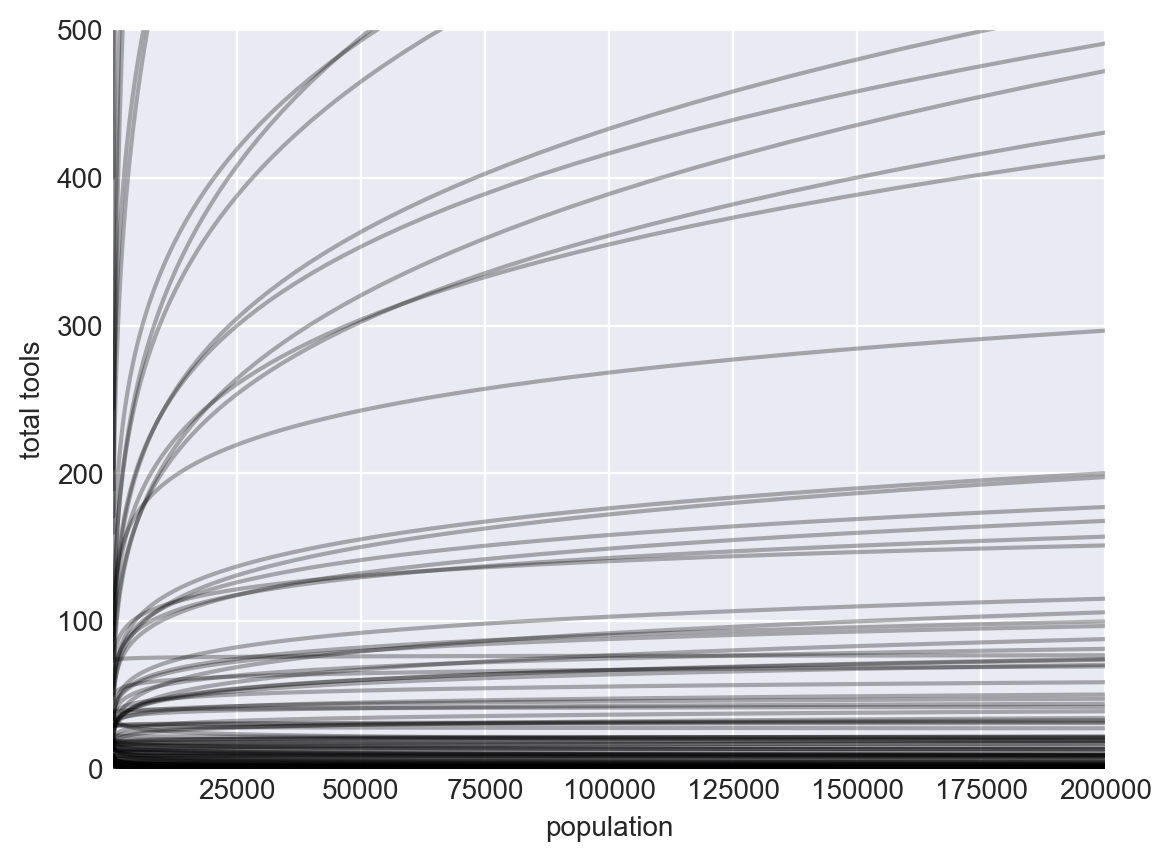

In [64]:
plt.figure()
plt.xlim(np.exp(x_seq[0]), np.exp(x_seq[-1]))
plt.ylim(0,500)
plt.xlabel('population')
plt.ylabel('total tools')

for i in range(N):
    plt.plot(np.exp(x_seq), lambda_vals[i, :], color = 'black', alpha = .3)


#### Code 11.45

In [ ]:
dat_list = pd.DataFrame({
    't': d.total_tools,
    'P': d.P,
    'cid': d.contact_id
})



with pm.Model() as m11_9:  # intercept only
    a = pm.Normal('a', 3, 0.5)
    lambdas = pm.Deterministic('lambdas', pm.math.exp(a))  # exp(a), not log(a)
    T = pm.Poisson('T', lambdas, observed=dat_list.t)
    trace_m11_9 = pm.sample(cores=1, idata_kwargs={'log_likelihood': True})

with pm.Model() as m11_10: 
    a = pm.Normal('a', 3, 0.5, shape=len(dat_list.cid.unique()))
    b = pm.Normal('b', 0, 0.2, shape=len(dat_list.cid.unique()))
    lambdas = pm.Deterministic('lambdas', pm.math.exp(a[dat_list.cid] + b[dat_list.cid] * dat_list.P)) 
    T = pm.Poisson('T', lambdas, observed=dat_list.t)
    trace_m11_10 = pm.sample(cores=1, idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


#### Code 11.46

In [127]:
az.compare({'m11.9': trace_m11_9, 'm11.10': trace_m11_10}, scale = 'log')

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m11.10,0,-42.61033,7.026131,0.00000,0.97787,6.216595,0.000000,True,log
m11.9,1,-70.64724,8.265148,28.03691,0.02213,15.901148,15.669794,True,log


In [128]:
# Check what scale d.P is actually on
print("d.P stats:")
print(f"  Min: {d.P.min()}")
print(f"  Max: {d.P.max()}")
print(f"  Mean: {d.P.mean()}")
print(f"  Std: {d.P.std()}")

print("\nP_seq range:", P_seq.min(), "to", P_seq.max())

# Check a few predictions
print("\nSample predictions:")
print(f"  post_a_low[0]: {post_a_low[0]}")
print(f"  post_b_low[0]: {post_b_low[0]}")
print(f"  P_seq[0]: {P_seq[0]}")
print(f"  lambda_low[0, 0]: {lambda_low[0, 0]}")
print(f"  lmu[0]: {lmu[0]}")

d.P stats:
  Min: -1.3613323987851729
  Max: 2.446557586097841
  Mean: 9.769962616701378e-16
  Std: 1.05409255338946

P_seq range: -1.4 to 3.0

Sample predictions:
  post_a_low[0]: 6.356859272320895
  post_b_low[0]: 0.014078602167468035
  P_seq[0]: -1.4
  lambda_low[0, 0]: 565.1828060162082
  lmu[0]: 335.98137620668564


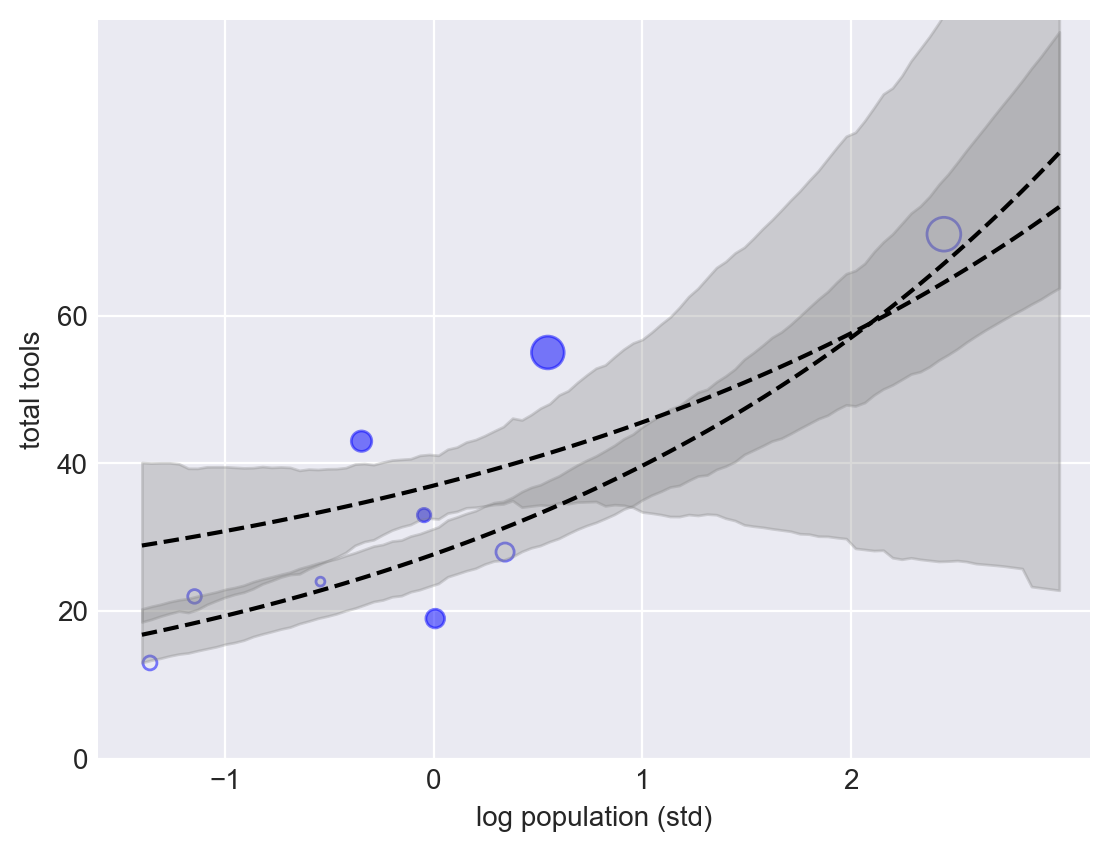

In [146]:
psis = az.loo(trace_m11_10, pointwise=True).pareto_k.values
dat_list = pd.DataFrame({
    't': d.total_tools,
    'P': d.P,
    'cid': d.contact_id,
    'k': psis
})

hi_contact = dat_list.loc[dat_list['cid'] == 1]
low_contact = dat_list.loc[dat_list['cid'] == 0]
low_k_scaled = scaler.fit_transform(low_contact[['k']]).flatten()
hi_k_scaled = scaler.fit_transform(hi_contact[['k']]).flatten()


# set up horizontal axis values to compute predictions at
ns =100
P_seq = np.linspace(-1.4, 3, ns)

plt.scatter(low_contact.P, low_contact.t, alpha=0.5, edgecolor='blue', 
           facecolor='none', s=(1 + low_k_scaled) * 50)  
plt.scatter(hi_contact.P, hi_contact.t, alpha=0.5, edgecolor='blue', 
           facecolor='blue', s=(1 + hi_k_scaled) * 50 )
plt.xlabel('log population (std)')
plt.ylabel('total tools')
plt.xlim(dat_list.P.min()- .25, dat_list.P.max() + .7)
plt.yticks([0,20,40,60])
plt.xticks([-1,0,1,2])
plt.ylim(0,100)

# predictions for cid = 0 (low contact)
post_a_low = trace_m11_10.posterior.a.sel(a_dim_0 = 0).values.reshape(-1,)
post_b_low = trace_m11_10.posterior.b.sel(b_dim_0 = 0).values.reshape(-1,)

lambda_low = np.exp(post_a_low[:,None] + post_b_low[:,None] * P_seq[None,:])
lmu = lambda_low.mean(0)
lci = az.hdi(lambda_low, hdi_prob=0.89)
plt.plot(P_seq, lmu, color = 'black', linestyle = '--')
plt.fill_between(P_seq, lci[:,0], lci[:,1], color = 'grey', alpha = 0.3)

# # precictoins for cid = 1 (high contact)
post_a_hi = trace_m11_10.posterior.a.sel(a_dim_0 = 1).values.reshape(-1,)
post_b_hi = trace_m11_10.posterior.b.sel(b_dim_0 = 1).values.reshape(-1,)

lambda_hi = np.exp(post_a_hi[:,None] + post_b_hi[:,None] * P_seq[None,:])
hmu = lambda_hi.mean(0)
hci = az.hdi(lambda_hi, hdi_prob=0.89)
plt.plot(P_seq, hmu, color = 'black', linestyle = '--')
plt.fill_between(P_seq, hci[:,0], hci[:,1], color = 'grey', alpha = 0.3);

#### Code 11.48

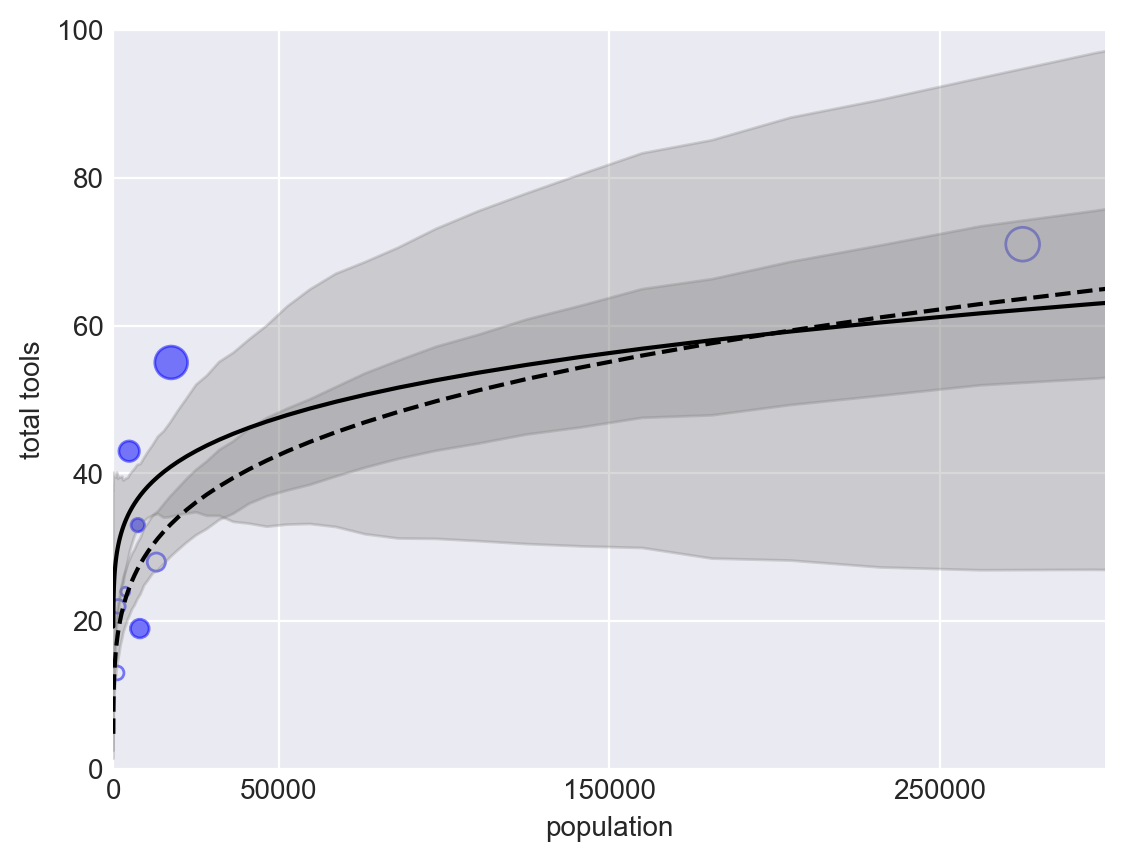

In [155]:
dat_list = pd.DataFrame({
    't': d.total_tools,
    'P': d.population,
    'cid': d.contact_id,
    'k': psis
})

hi_contact = dat_list.loc[dat_list['cid'] == 1]
low_contact = dat_list.loc[dat_list['cid'] == 0]
low_k_scaled = scaler.fit_transform(low_contact[['k']]).flatten()
hi_k_scaled = scaler.fit_transform(hi_contact[['k']]).flatten()


# set up horizontal axis values to compute predictions at
ns =100
P_seq = np.linspace(-5, 3, ns)
#1.53 is the sd of log(population)
# 9 is the mean of log(population)
pop_seq = np.exp(P_seq * 1.53 + 9)

plt.scatter(low_contact.P, low_contact.t, alpha=0.5, edgecolor='blue', 
           facecolor='none', s=(1 + low_k_scaled) * 50)  
plt.scatter(hi_contact.P, hi_contact.t, alpha=0.5, edgecolor='blue', 
           facecolor='blue', s=(1 + hi_k_scaled) * 50 )
plt.xlabel('population')
plt.ylabel('total tools')
plt.xlim(pop_seq.min(), 300000)
plt.xticks([0,50000,150000,250000])
plt.ylim(0,100)

# predictions for cid = 0 (low contact)
post_a_low = trace_m11_10.posterior.a.sel(a_dim_0 = 0).values.reshape(-1,)
post_b_low = trace_m11_10.posterior.b.sel(b_dim_0 = 0).values.reshape(-1,)

lambda_low = np.exp(post_a_low[:,None] + post_b_low[:,None] * P_seq[None,:])
lmu = lambda_low.mean(0)
lci = az.hdi(lambda_low, hdi_prob=0.89)
plt.plot(pop_seq, lmu, color = 'black', linestyle = '--')
plt.fill_between(pop_seq, lci[:,0], lci[:,1], color = 'grey', alpha = 0.3)

# # precictoins for cid = 1 (high contact)
post_a_hi = trace_m11_10.posterior.a.sel(a_dim_0 = 1).values.reshape(-1,)
post_b_hi = trace_m11_10.posterior.b.sel(b_dim_0 = 1).values.reshape(-1,)

lambda_hi = np.exp(post_a_hi[:,None] + post_b_hi[:,None] * P_seq[None,:])
hmu = lambda_hi.mean(0)
hci = az.hdi(lambda_hi, hdi_prob=0.89)
plt.plot(pop_seq, hmu, color = 'black', linestyle = '-')
plt.fill_between(pop_seq, hci[:,0], hci[:,1], color = 'grey', alpha = 0.3);

#### Code 11.49

In [ ]:
dat2 = pd.DataFrame({
    't': d.total_tools,
    'P': d.population,
    'cid': d.contact_id
})

with pm.Model() as m11_11:
    g = pm.Exponential('g', 1)
    a = pm.Normal('a', 1,1, shape = len(dat2.cid.unique()))
    b = pm.Exponential('b', 1, shape = len(dat2.cid.unique()))
    lambdas = pm.Deterministic('lambda', pm.math.exp(a[dat2.cid.values]) * dat2.P.values ** b[dat2.cid.values] / g)
    T = pm.Poisson('T', lambdas)
    trace_m11_11 = pm.sample(cores = 1, idata_kwargs = {'log_likelihood': True})
pm.summary(trace_m11_11)

##### Code 11.50

In [174]:
num_days = 30
y = np.random.poisson(1.5, num_days)


#### Code 11.51

In [178]:
num_weeks = 4
y_new = np.random.poisson(.5 * 7, num_weeks)


#### Code 11.52

In [181]:
y_all = np.concatenate([y, y_new])
exposure = np.concatenate([np.repeat(1, 30), np.repeat(7, 4)])
monastery = np.concatenate([np.repeat(0, 30), np.repeat(1, 4)])
d = pd.DataFrame({
    'y': y_all,
    'days': exposure,
    'monastery': monastery
})


#### Code 11.53

In [184]:
d['log_days'] = np.log(d.days)


with pm.Model() as m11_12:
    b = pm.Normal('b', 0,1)
    a = pm.Normal('a', 0,1)
    lambdas = pm.Deterministic('lambdas', pm.math.exp(d.log_days.values + a + b*d.monastery.values))
    y = pm.Poisson('y', lambdas, observed = d.y)
    trace_m11_12 = pm.sample(cores = 1, idata_kwargs = {'log_likelihood':True})

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


#### Code 11.54

In [ ]:
lambda_old = (np.exp(trace_m11_12.posterior.a)).values
lambda_new = (np.exp(trace_m11_12.posterior.a + trace_m11_12.posterior.b)).values

lambdas_comb = xr.Dataset({
    'lambda_old': (['chain', 'draw'], lambda_old),
    'lambda_new': (['chain', 'draw'], lambda_new)
})

pm.summary(lambdas_comb)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_old,1.724,0.230,1.308,2.159,0.007,0.005,1182.0,1015.0,1.0
lambda_new,0.641,0.149,0.353,0.902,0.004,0.003,1597.0,1445.0,1.0


#### Code 11.55


In [310]:
N = 500
income = [1,2,5]
score = [.5 * i for i in income]
p = softmax([score[0], score[1], score[2]])

career = np.repeat(0,N)

np.random.seed(34302)
for i in range(len(career)):
    career[i] = np.random.choice([0,1,2], size = 1, p = p)
print(p)
print(career)

[0.09962365 0.16425163 0.73612472]
[2 1 2 2 2 2 2 2 2 0 2 1 2 1 0 2 2 1 1 2 2 0 1 1 2 2 0 1 0 2 2 0 2 2 2 2 2
 2 2 2 1 2 2 2 1 1 0 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 1 0 0 2 2 0
 2 2 2 2 2 0 2 2 2 0 2 2 0 2 1 2 2 0 2 2 1 2 1 2 0 2 2 1 2 2 2 2 2 2 0 2 0
 0 2 2 2 0 2 2 2 2 2 2 1 1 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 0 2 2 1 0 2 1 2 1
 1 2 1 2 0 1 2 2 2 0 2 0 2 2 2 2 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1
 0 2 0 2 0 2 0 2 1 2 2 2 1 0 1 2 2 2 2 1 2 1 2 2 1 2 2 1 1 2 0 1 1 2 0 2 1
 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 1 2 2 1 2
 2 2 1 1 1 2 2 2 2 1 2 0 2 2 1 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 0 2 2
 1 2 2 2 2 2 2 2 1 0 1 1 1 2 2 2 1 2 2 2 2 1 1 2 0 2 2 2 1 2 1 2 2 2 2 2 2
 2 2 2 2 0 2 1 2 1 2 2 2 2 2 2 1 2 2 1 1 2 0 2 2 2 0 0 2 1 1 2 2 2 1 2 2 2
 2 2 2 2 2 2 0 1 1 2 2 2 1 2 2 2 1 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2
 2 2 1 2 2 2 2 2 2 2 2 2 0 2 2 1 1 2 2 1 2 2 2 1 2 2 1 2 2 2 2 2 1 2 2 2 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 1 1 2 2 1 2 2 2 2 2 2 1 

#### Code 11.56

In [327]:
with pm.Model() as m11_13:
    a = pm.Normal('a', 0, 1, shape=2)
    b = pm.TruncatedNormal('b', mu=0, sigma=0.5, lower=0)
    
    s = pm.math.stack([a[0]+ b * income[0], 
                       a[1]+ b * income[1], 
                       0]) 
    
    p = pm.math.softmax(s)
    print(p.eval())
    
    career = pm.Categorical('career', p=p, observed=career)
    

[0.62300266 0.14470325 0.23229409]


#### Code 11.57

In [312]:
with m11_13:
    trace_m11_13 = pm.sample(cores=1, idata_kwargs={'log_likelihood': True})
pm.summary(trace_m11_13)

#these results are notably different from the rcode and im not sure why. its run correctly and mimics the expected result but are very different 

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-2.022,0.213,-2.413,-1.610,0.038,0.028,40.0,31.0,1.04
a[1],-1.589,0.283,-2.161,-1.175,0.052,0.039,39.0,21.0,1.05
b,0.160,0.135,0.000,0.431,0.026,0.021,43.0,54.0,1.05


#### Code 11.58

In [ ]:
post_a = trace_m11_13.posterior['a'].values.reshape(-1, 2) 
post_b = trace_m11_13.posterior['b'].values.flatten()


s1 = post_a[:, 0] + post_b * income[0]
s2_orig = post_a[:, 1] + post_b * income[1]
s2_new = post_a[:, 1] + post_b * income[1] * 2  

n_samples = len(post_b)
scores_orig = np.column_stack([s1, s2_orig, np.zeros(n_samples)])
scores_new = np.column_stack([s1, s2_new, np.zeros(n_samples)])

p_orig = softmax(scores_orig, axis=1)
p_new = softmax(scores_new, axis=1)

p_diff = p_new[:, 1] - p_orig[:, 1]

pd.DataFrame({'mean': p_diff.mean(), 'sd': p_diff.std(), '5.5%': np.quantile(p_diff,0.055), '94.5%': np.quantile(p_diff,0.945)}, index = ['p_diff'])

# this also has very different results beacuse hte upstream data is producing such different results.

,mean,sd,5.5%,94.5%
p_diff,0.058734,0.054834,0.003421,0.169055


#### Code 11.59

In [330]:
N = 500
# simulate family incomes for each individual 
family_income = np.random.uniform(0,1,N)

# assign a unique coefficient for each type of event
b = [-2,0,2]

career = np.repeat(0,N) 

for i in range(len(career)): 
    score = 0.5 * np.arange(1, 4) + b * np.array(family_income[i])
    p = softmax(score)
    career[i] = np.random.choice([0,1,2], size = 1, p = p)

with pm.Model() as m11_14:
    a = pm.Normal('a', 0, 1.5, shape=len(score)-1)
    b = pm.Normal('b', 0, 1, shape=len(b)-1)
    

    s_non_pivot = a + b * family_income[:, None]  
    
    s = pm.math.concatenate([s_non_pivot, pm.math.zeros((N, 1))], axis=1)
    
    p = pm.math.softmax(s, axis=1)  
    
    career_obs = pm.Categorical('career', p=p, observed=career)
    
    trace_m11_14 = pm.sample(cores=1)

pm.summary(trace_m11_14)
    

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-1.215,0.272,-1.697,-0.683,0.009,0.006,971.0,1017.0,1.0
a[1],-0.412,0.198,-0.786,-0.047,0.006,0.004,1175.0,1377.0,1.0
b[0],-2.460,0.541,-3.453,-1.442,0.017,0.012,1025.0,1157.0,1.0
b[1],-2.253,0.383,-2.946,-1.533,0.011,0.008,1153.0,1216.0,1.0


#### Code 11.60

In [334]:
d = pd.read_csv('data/UCBadmit.csv', sep = ';')
d.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


#### Code 11.61

In [337]:
# binomial model of overall admission probability
with pm.Model() as m_binom:
    a = pm.Normal('a', 0, 1.5)
    p = pm.Deterministic('p', pm.math.sigmoid(a)) 
    admit = pm.Binomial('admit', d.applications, p , observed = d.admit)
    trace_m_binom = pm.sample(cores = 1, idata_kwargs = {'log_likelihood': True})
    
display(pm.summary(trace_m_binom))

with pm.Model() as m_pois:
    a1, a2 = pm.Normal('a1', 0, 1.5), pm.Normal('a2', 0, 1.5) 
    lambda1 = pm.Deterministic('lambda1', pm.math.exp(a1))
    lambda2 = pm.Deterministic('lambda2', pm.math.exp(a2))
    
    admit = pm.Poisson('admit', lambda1 , observed = d.admit)
    rej = pm.Poisson('rej', lambda2 , observed = d.reject)
    trace_m_pois = pm.sample(cores = 1, idata_kwargs = {'log_likelihood': True})
    
pm.summary(trace_m_pois)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.457,0.031,-0.517,-0.400,0.001,0.001,766.0,1302.0,1.01
p,0.388,0.007,0.373,0.401,0.000,0.000,766.0,1302.0,1.01


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a1, a2]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,4.984,0.025,4.935,5.028,0.001,0.000,1885.0,1244.0,1.0
a2,5.441,0.019,5.407,5.478,0.000,0.000,1992.0,1637.0,1.0
lambda1,146.054,3.627,138.751,152.316,0.083,0.059,1885.0,1244.0,1.0
lambda2,230.664,4.442,222.956,239.326,0.099,0.070,1992.0,1637.0,1.0


#### Code 11.62

In [339]:
inv_logit(trace_m_binom.posterior.a.values.flatten().mean())

0.38781366741619944

#### Code 11.63

In [ ]:
a1 = trace_m_pois.posterior.a1.values.flatten().mean()
a2 = trace_m_pois.posterior.a2.values.flatten().mean()

np.exp(a1) / (np.exp(a1) + np.exp(a2))


0.38767215220179024

#### Code 11.64

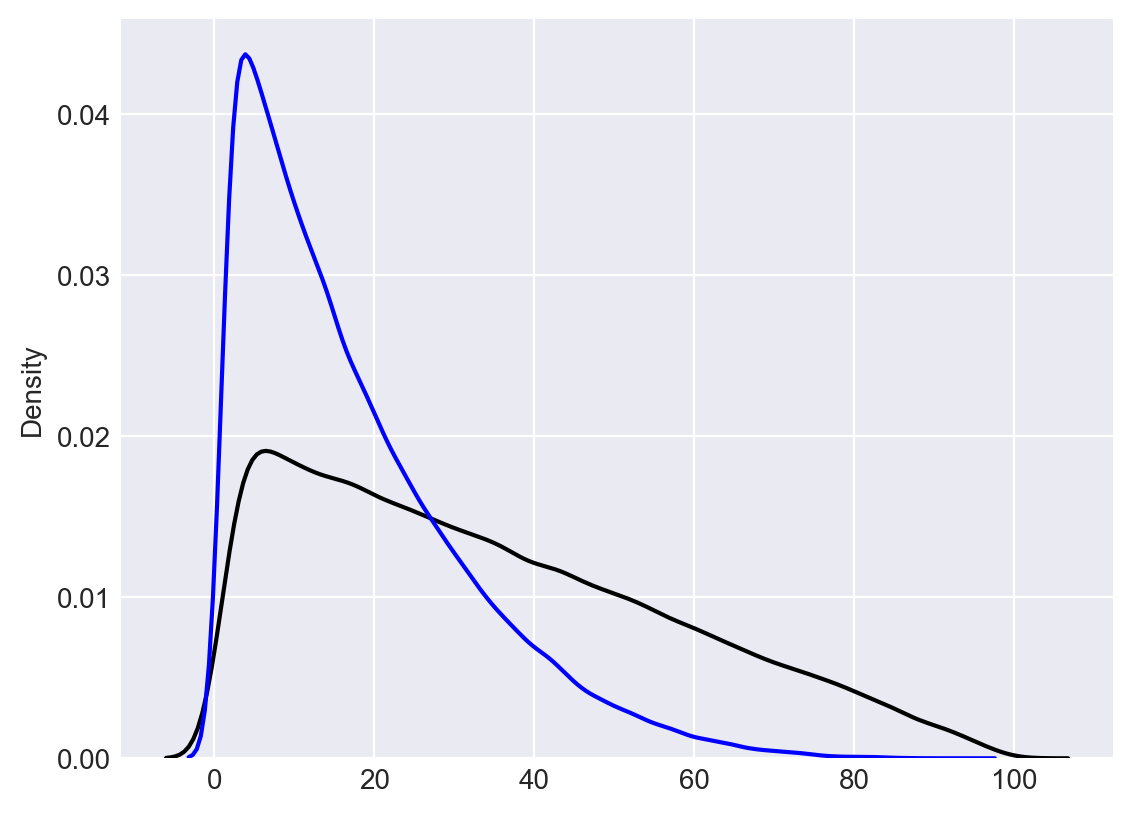

In [356]:
x2 = np.random.uniform(1, 100, size=(int(1e5), 2)).min(axis=1)
x5 = np.random.uniform(1, 100, size=(int(1e5), 5)).min(axis=1)

sns.kdeplot(x2, color = 'black')
sns.kdeplot(x5, color = 'blue');

#### Code 11.65

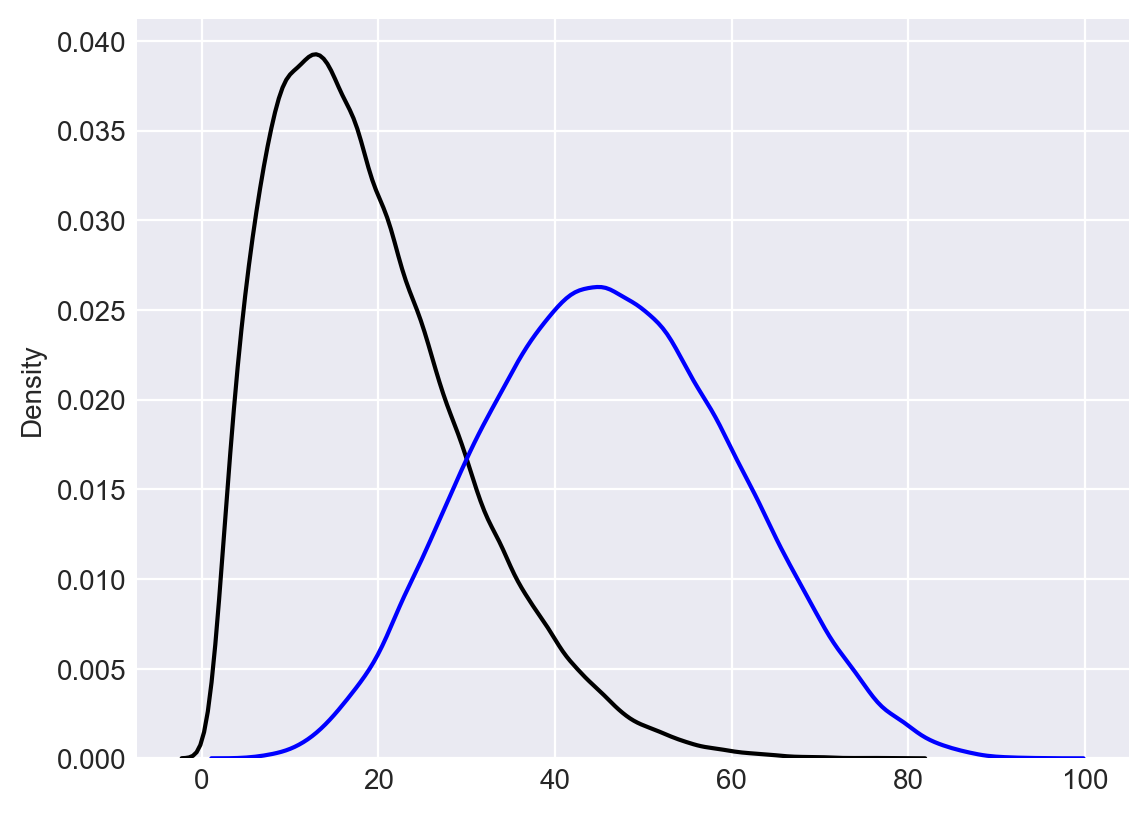

In [365]:
N = 10
x2 = np.sort(np.random.uniform(1, 100, size=(int(1e5), N)), axis=1)[:, 2-1]
x5 = np.sort(np.random.uniform(1, 100, size=(int(1e5), N)), axis=1)[:, 5-1]

sns.kdeplot(x2, color = 'black')
sns.kdeplot(x5, color = 'blue');


#### Code 11.66

In [369]:
d.columns

Index(['id', 'days_to_event', 'date_out', 'out_event', 'date_in', 'in_event',
       'breed', 'color', 'intake_age', 'adopt'],
      dtype='object')

In [ ]:
d = pd.read_csv('data/AustinCats.csv', sep = ';')

d['adopt'] = np.where(d.out_event == 'Addoption', 1, 0)

dat = pd.DataFrame({ 
    'days_to_event': d.days_to_event.astype(int),
    'color_id': np.where(d.color == 'black', 0, 1),
    'adopted': d.adopt
})

with pm.Model() as m11_15:
    a = pm.Normal('a', 0, 1, shape = len(dat.color_id.unique()))
    mu = pm.Deterministic('mu', pm.math.exp(a[dat.color_id.values]))
    lambdas = pm.Deterministic('lambdas', 1.0/mu)
    lam = pm.Exponential('lam', 1)
    days_to_event_adopted_0 = pm.Deterministic('days_to_event_adopted_0', -lam * lambdas, observed = dat.days_to_event[dat.adopted == 0])
    days_to_event_adopted_1 = pm.Exponential('days_to_event_adopted_1', lambdas, observed = dat.days_to_event[dat.adopted == 1])
    
    trace_m11_15 = pm.sample(cores = 1, idata_kwargs = {'log_likelihood': True})
    
    
pm.summary(trace_m11_15)
    

TypeError: Deterministic() got an unexpected keyword argument 'observed'